# Exploitation - 1

In the exploitation task, we aim to predict the edges and the type of edges (transport routes). We start with Hand crafted features, followed by node embedding and finally use GNNs. In this notebook, we will work using the hand-crafted features.

In [1]:
import glob
import pickle
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.colors as mcolors

from enum import Enum
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
rel_data_folder_path = pathlib.Path("./../../data")
transport_data_path = rel_data_folder_path.joinpath('transport_data')
city_network = rel_data_folder_path.joinpath('network_graphs')
city_network_graphs = city_network.joinpath('graphs')
city_network_graphs_dir = city_network_graphs.joinpath('directed_graphs')
city_network_bones = city_network.joinpath('nodes-edges')

checkpoints_folder_path = rel_data_folder_path.joinpath("checkpoints")
city_network_graphs_dir_betweenness = checkpoints_folder_path.joinpath('directed_graphs_betweenness')
city_network_graphs_dir_edge_pred_linreg = checkpoints_folder_path.joinpath('linreg-single-class')
city_network_graphs_dir_edge_pred_linreg_hco = city_network_graphs_dir_edge_pred_linreg.joinpath('handcraft_only')
city_network_graphs_dir_edge_pred_linreg_commono = city_network_graphs_dir_edge_pred_linreg.joinpath('commonft_only')
city_network_graphs_dir_edge_pred_linreg_all = city_network_graphs_dir_edge_pred_linreg.joinpath('both')

In [3]:
# Define enum for route types
class RouteType(Enum):
    tram, subway, rail, bus, ferry, cablecar, gondola = range(7)

def load_city_graphs(city_name, graphs_folder):
    with open(graphs_folder.joinpath(city_name.lower() + '.gpickle'), 'rb') as f:
        city_graph = pickle.load(f)
    return city_graph

def load_all_cities_graphs(cities: list[str], graphs_folder: pathlib.Path):
    return {city: load_city_graphs(city, graphs_folder) for city in cities}

def classifier_svm(features, targets, labels, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=False, input_feature_names=None, title=None):
    ''' 
    INPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
    targets: target vector of dimensions (N, ) (N: number of samples)
    labels: vector of all possible labels for nodes in the graph 
    feature_selection: a flag for whether to use feature selction, bool
    num_features: number of features used from feature selesction
    test_size: please set to 0.5 for reproducibility
    seed: please set to 0 for reproducibility
    verbose: print and plot result or not, bool
    input_feature_names: Names for the input features, None by default
    title: Title for the confusion matrix

    OUTPUT:
    cm: confusion matrix on the test set
    f1: weighted f1 score on the test set

    '''

    # Split the data into training and testing sets, with test_size=0.5
    X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=seed, test_size=test_size)

    if feature_selection:
        ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
        feature_selector = SelectKBest(f_classif, k=num_features)
        X_train_sel = feature_selector.fit_transform(X_train, y_train)
        clf = make_pipeline(StandardScaler(), svm.SVC(class_weight='balanced', random_state=seed))
        clf.fit(X_train_sel, y_train)
        ## Print the scores for individual features.
        print("\nTo select the top {} features:".format(num_features))
        if not input_feature_names:
            input_feature_names = ["feature_{}".format(str(i)) for i in range(features.shape[1])]
        print("\tThe feature scorees are:")
        print("\t{}".format({ft_name:ft_score for ft_name, ft_score in zip(input_feature_names, feature_selector.scores_)}))
        print("\tThe selected features are {}".format(feature_selector.get_feature_names_out(input_features=input_feature_names)))
    else:
        ## Build and train the ML model, including normalization and Support Vector Classifier.
        clf = make_pipeline(StandardScaler(), svm.SVC(class_weight='balanced', random_state=seed))
        clf.fit(X_train, y_train)

    # Use the model to predict the labels of the test data
    if feature_selection:
        X_test_sel = feature_selector.transform(X_test)
        y_pred = clf.predict(X_test_sel)
    else:
        y_pred = clf.predict(X_test)
    # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
    cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    acc = metrics.accuracy_score(y_test, y_pred)

    if verbose:
        print("The Weighted F1 score is {}".format(f1))
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        if title:
            disp.ax_.set_title(title)
        plt.show()
    return cm, f1, acc

def classifier(features, targets, labels, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=False, input_feature_names=None, title=None):
    ''' 
    INPUT:
    features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
    targets: target vector of dimensions (N, ) (N: number of samples)
    labels: vector of all possible labels for nodes in the graph 
    feature_selection: a flag for whether to use feature selction, bool
    num_features: number of features used from feature selesction
    test_size: please set to 0.5 for reproducibility
    seed: please set to 0 for reproducibility
    verbose: print and plot result or not, bool
    input_feature_names: Names for the input features, None by default
    title: Title for the confusion matrix

    OUTPUT:
    cm: confusion matrix on the test set
    f1: weighted f1 score on the test set

    '''

    # Split the data into training and testing sets, with test_size
    X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets, random_state=seed, test_size=test_size)

    if feature_selection:
        ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
        feature_selector = SelectKBest(f_classif, k=num_features)
        X_train_sel = feature_selector.fit_transform(X_train, y_train)
        clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=seed))
        clf.fit(X_train_sel, y_train)
        ## Print the scores for individual features.
        print("\nTo select the top {} features:".format(num_features))
        if not input_feature_names:
            input_feature_names = ["feature_{}".format(str(i)) for i in range(features.shape[1])]
        print("\tThe feature scorees are:")
        print("\t{}".format({ft_name:ft_score for ft_name, ft_score in zip(input_feature_names, feature_selector.scores_)}))
        print("\tThe selected features are {}".format(feature_selector.get_feature_names_out(input_features=input_feature_names)))
    else:
        ## Build and train the ML model, including normalization and Logi.
        clf = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=seed))
        clf.fit(X_train, y_train)

    # Use the model to predict the labels of the test data
    if feature_selection:
        X_test_sel = feature_selector.transform(X_test)
        y_pred = clf.predict(X_test_sel)
    else:
        y_pred = clf.predict(X_test)
    # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
    cm = metrics.confusion_matrix(y_test, y_pred, labels=labels)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
    acc = metrics.accuracy_score(y_test, y_pred)

    if verbose:
        print("\t\tThe Weighted F1 score is {}".format(f1))
        print("\t\tThe Accuracy is {}".format(acc))
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        if title:
            disp.ax_.set_title(title)
        plt.show()
    return cm, f1, acc

def train_model(cities_graphs_dicts, results_path, incl_node_fts, incl_common_fts):
    
    results_path.mkdir(parents=True, exist_ok=True)

    for city, city_graphs in tqdm(cities_graphs_dicts.items()):
        city_graphs_scores = {}
        for route_type, route_graph in city_graphs.items():
            if ((route_type in ["full"]) or (route_graph is None)):
                city_graphs_scores[route_type] = {"f1": None, "cm": np.array([[0, 0], [0, 0]]), "acc": None}
                continue

            if ((route_type in ["bus"]) and (city in ["sydney"])):
                city_graphs_scores[route_type] = {"f1": None, "cm": np.array([[0, 0], [0, 0]]), "acc": None}
                continue
                
            features_edges, targets_edge, labels_edge = generate_edge_feature_targets(route_graph,
                                                                                      incl_node_fts=incl_node_fts,
                                                                                      incl_common_fts=incl_common_fts)

            
            cm, f1score, accuracy = classifier(features_edges, targets_edge, labels_edge,
                                     feature_selection=False, test_size=test_size,
                                     seed=seed, verbose=False)

            city_graphs_scores[route_type] = {"f1": f1score, "cm": cm, "acc": accuracy}

        with open(results_path.joinpath('{}.gpickle'.format(city)), 'wb') as f:
            pickle.dump(city_graphs_scores, f, pickle.HIGHEST_PROTOCOL)
            
        print("Results saved")

def plot_cms(scores_dict, mode):
    fig, axes = plt.subplots(5, 5, figsize=(16, 16), sharex=False, sharey=False)
    labels = [0, 1]
    for idx, (city, city_scores_lr) in tqdm(enumerate(scores_dict.items())):

        row = int(idx / 5)
        col = idx % 5

        cm = city_scores_lr[mode]['cm']
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(ax=axes[row][col], values_format='')
        disp.ax_.set_title(city)

    fig.suptitle('Confusion Matrix for {} networks edge prediction (LogReg)'.format(mode))
    fig.tight_layout()

def plot_scores(scores_df, score_string="f1", features="all"):
    plt.figure(figsize=(12,10))
    sns.scatterplot(data=scores_df, x="route", y=score_string, style="city", hue='city')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=3)
    plt.title('{} score of edge prediction using {} features (LogReg)'.format(score_string, features))

In [4]:
mcolors = list(mcolors.BASE_COLORS)
seed = 0
test_size = 0.3

In [ ]:
cities = sorted([x.stem for x in city_network_graphs_dir.glob('*.gpickle')])
cities_graphs_dir = load_all_cities_graphs(cities, city_network_graphs_dir_betweenness)

## Task - 1

In the first task, we predict the edges between the given nodes only when considering a single route type. 

### Hand-crafted features

For this task we consider the following node features

1. In degree centrality
2. Out degree centrality
3. Betweenness centrality
4. Katz centrality

and the following common features
1. fraction of common incoming neighbors among all incoming neighbors between the nodes
2. fraction of common outgoing neighbors among all outgoing neighbors between the nodes

To compute the edge features between nodes, we combine the node features by subtracting the source node features from the target node features and then add the edge features.

In [ ]:
def generate_edge_feature_targets(graph: nx.Graph, incl_node_fts=True, incl_common_fts=True) -> list[np.ndarray]:
    """
    Generate a node feature matrix for a given graph.

    Args:
        graph: The input graph.
        incl_node_fts: Boolean to consider node features in creating the edge features
        incl_common_fts: Boolean to consider common outgoing and incoming neighbors) in creating the edge features

    Returns:
        edge_features: The edge features.
        targes: target vector with values of {0, 1}
        labels: vector of all possible targets in the graph 

    """
    
    nodes = list(graph.nodes())
    num_nodes = len(nodes)
    
    edge_features = []
    targets = []
    labels = []
    
    if incl_node_fts:
        in_degree_centrality = nx.in_degree_centrality(graph)
        out_degree_centrality = nx.out_degree_centrality(graph)
        betweenness_centrality = nx.get_node_attributes(graph, "betweenness")
        katz_centrality = nx.katz_centrality(graph)
    
    
    for idx1 in range(num_nodes):
        node1 = nodes[idx1]
        # Get the incoming neighbors of the source node
        source_incoming = set(graph.predecessors(node1))
        # Get the outgoing neighbors of the source node
        source_outgoing = set(graph.successors(node1))
        node_1_feat = []
        if incl_node_fts:
            node_1_feat = [
                in_degree_centrality[node1],
                out_degree_centrality[node1], 
                betweenness_centrality[node1],
                katz_centrality[node1]
            ]
        for idx2 in range(num_nodes):
            node2 = nodes[idx2]
            node_2_feat = []
            if incl_node_fts:
                node_2_feat = [
                    in_degree_centrality[node2],
                    out_degree_centrality[node2], 
                    betweenness_centrality[node2],
                    katz_centrality[node2]
                ]
            
            edge_feature = np.subtract(node_2_feat, node_1_feat)
          
            if incl_common_fts:
                if idx1 == idx2:
                    frac_comm_incoming = 1
                    frac_comm_outgoing = 1
                else:
                    # Get the incoming neighbors of the target node
                    target_incoming = set(graph.predecessors(node2))

                    # Get the outgoing neighbors of the target node
                    target_outgoing = set(graph.successors(node2))

                    union_incoming = len(source_incoming.union(target_incoming))
                    union_outgoing = len(source_outgoing.union(target_outgoing))

                    if union_incoming == 0:
                        frac_comm_incoming = 0
                    else:
                        frac_comm_incoming = len(source_incoming.intersection(target_incoming)) / union_incoming

                    if union_outgoing == 0:
                        frac_comm_outgoing = 0
                    else:
                        frac_comm_outgoing = len(source_outgoing.intersection(target_outgoing)) / union_outgoing
            
                edge_feature = np.concatenate((edge_feature, np.array([frac_comm_incoming, frac_comm_outgoing])))
            
            edge_features.append(edge_feature)
            targets.append(1 if graph.has_edge(node1, node2) else 0)
            
    return np.array(edge_features), np.array(targets), np.unique(targets)

## Modelling

Run the next cells to re run the training and save the accuracy, confusion matrix and the f1score. Otherwise, skip the next section and run the cell after it to load the saved scores.

We train a Logistic Regression model for each transport type in each city with 70:30 split of training and testing data while stratifying it based on the targets. The Sydney bus network is ignored as the memory is not sufficient for it.

We run three experiments in this part. First, we only use the node features i.e. In degree centrality, Out degree centrality, Betweenness centrality and Katz centrality. Second, only using the common incoming and outgoing neighbours features and lastly, using all 6 features.

### Only using Node features.

In [ ]:
cities_graphs_dir = {'venice': {'ferry': cities_graphs_dir['venice']['ferry']}}

In [ ]:
train_model(cities_graphs_dir, city_network_graphs_dir_edge_pred_linreg_hco, incl_node_fts=True, incl_common_fts=False)

### Only using Common features.

In [ ]:
train_model(cities_graphs_dir, city_network_graphs_dir_edge_pred_linreg_commono, incl_node_fts=False, incl_common_fts=True)

### Using all features.

In [ ]:
train_model(cities_graphs_dir, city_network_graphs_dir_edge_pred_linreg_all, incl_node_fts=True, incl_common_fts=True)

## Results

- The results of cablecar are not inlcuded as there is only one city with three stops in that category.

### Only using Node features.

In [5]:
cities_reg = sorted([x.stem for x in city_network_graphs_dir_edge_pred_linreg_hco.glob('*.gpickle')])
cities_graphs_scores_hco = load_all_cities_graphs(cities_reg, city_network_graphs_dir_edge_pred_linreg_hco)
cities_graphs_scores_hco_df = pd.DataFrame.from_dict({(i,j): cities_graphs_scores_hco[i][j] 
                           for i in cities_graphs_scores_hco.keys() 
                           for j in cities_graphs_scores_hco[i].keys()},
                       orient='index').reset_index(drop=False, names=["city", "route"])

cities_graphs_scores_hco_df = cities_graphs_scores_hco_df[~cities_graphs_scores_hco_df['route'].isin(['full', 'cablecar'])]
# cities_graphs_scores_hco_df.pivot(index='city', columns='route', values='f1')

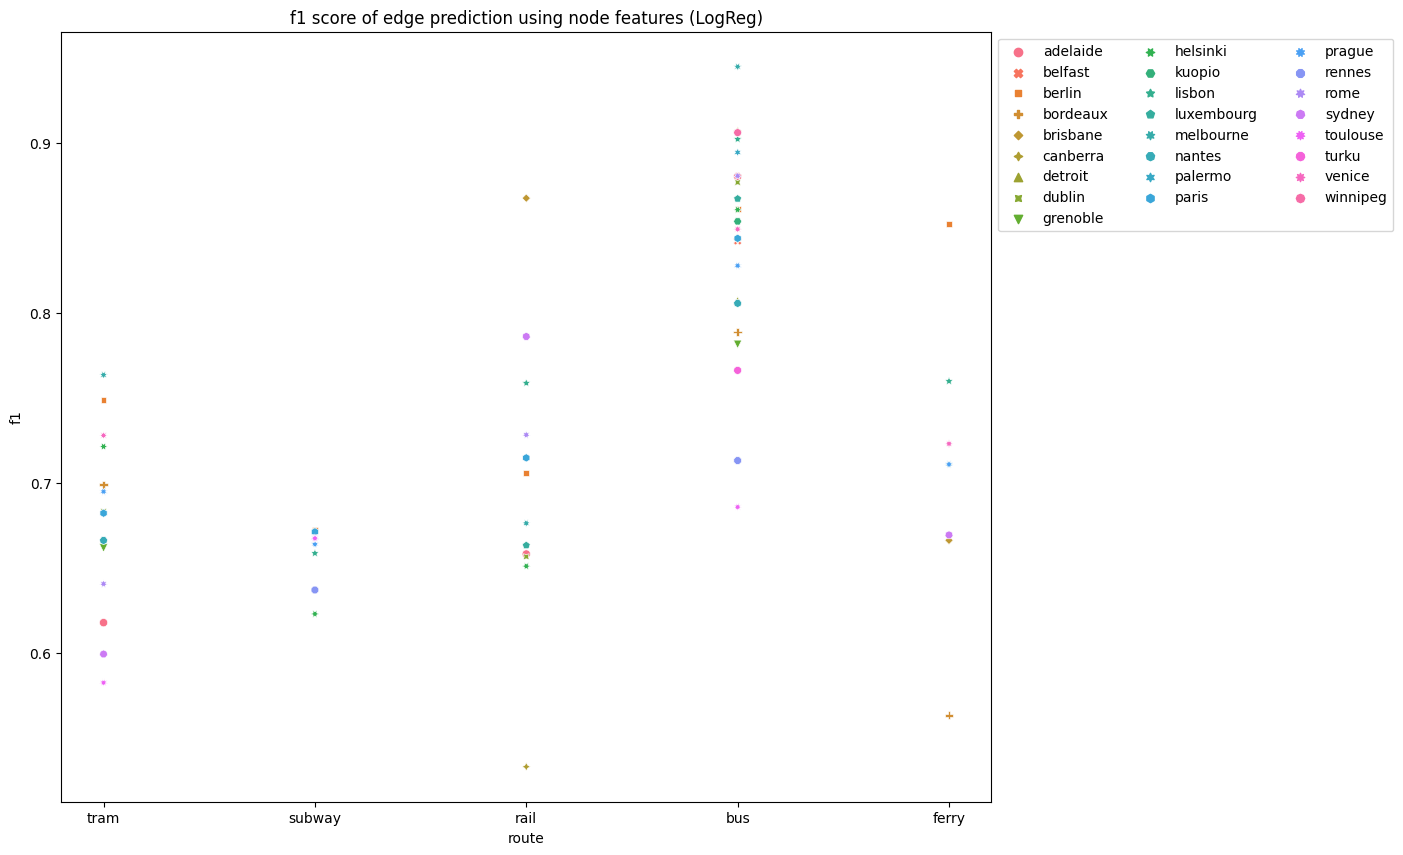

In [6]:
plot_scores(cities_graphs_scores_hco_df, features="node")

### Only using Common features.

In [7]:
cities_reg = sorted([x.stem for x in city_network_graphs_dir_edge_pred_linreg_commono.glob('*.gpickle')])
cities_graphs_scores_commono = load_all_cities_graphs(cities_reg, city_network_graphs_dir_edge_pred_linreg_commono)
cities_graphs_scores_commono_df = pd.DataFrame.from_dict({(i,j): cities_graphs_scores_commono[i][j] 
                           for i in cities_graphs_scores_commono.keys() 
                           for j in cities_graphs_scores_commono[i].keys()},
                       orient='index').reset_index(drop=False, names=["city", "route"])

cities_graphs_scores_commono_df = cities_graphs_scores_commono_df[~cities_graphs_scores_commono_df['route'].isin(['full', 'cablecar'])]
# cities_graphs_scores_common_df.pivot(index='city', columns='route', values='f1')

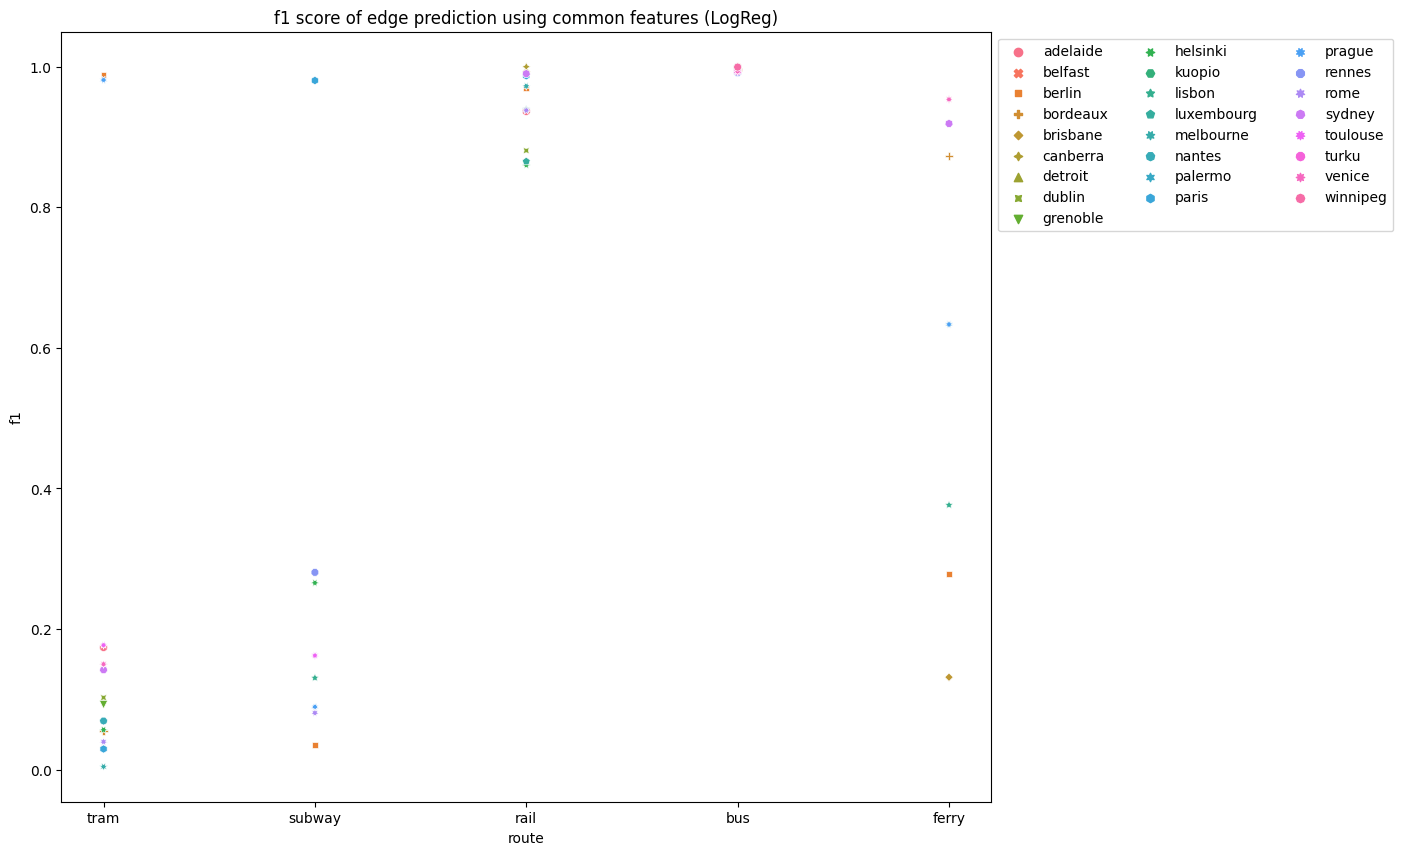

In [8]:
plot_scores(cities_graphs_scores_commono_df, features="common")

25it [00:00, 129.59it/s]


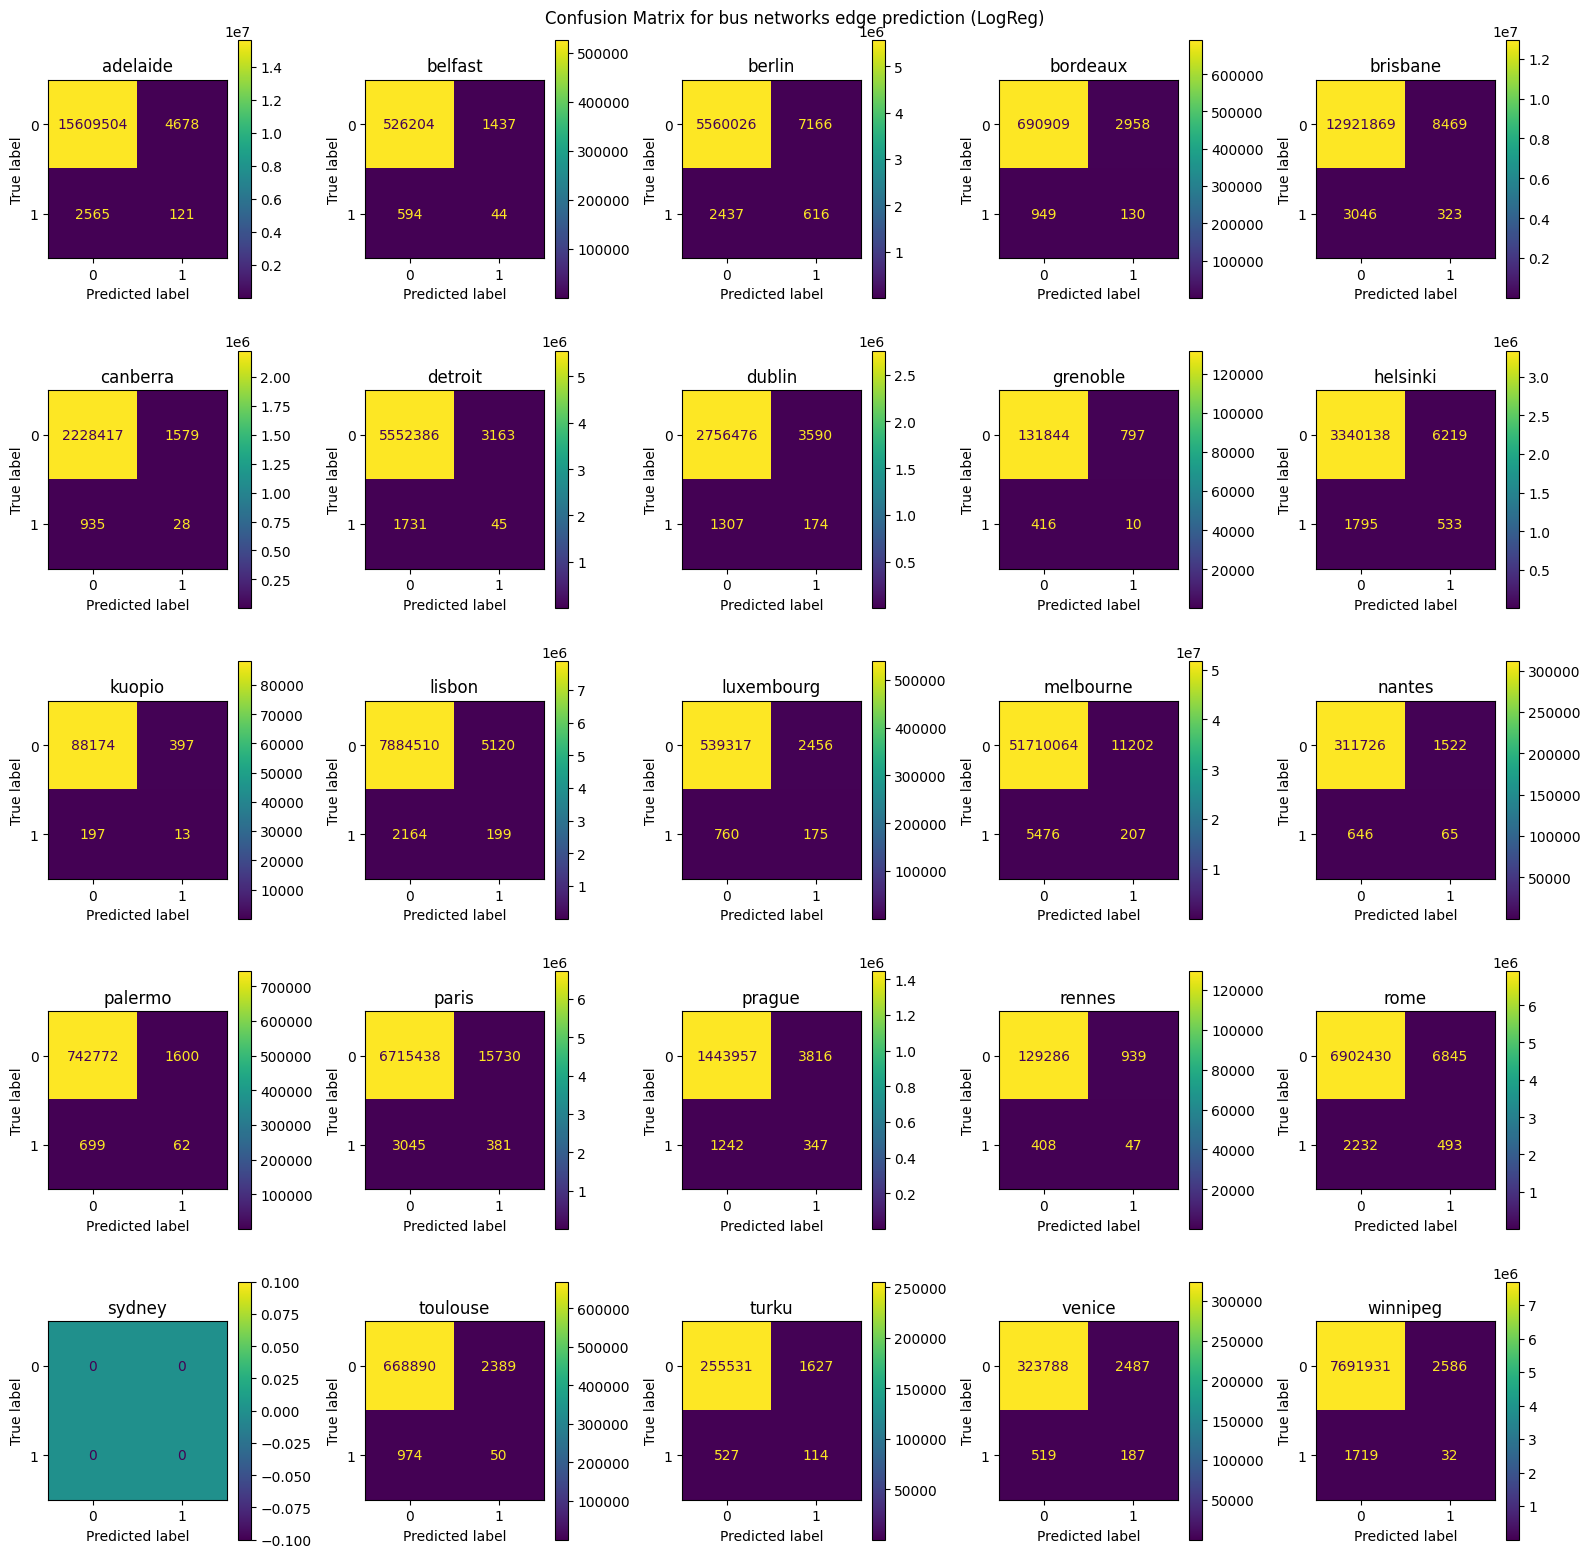

In [12]:
plot_cms(cities_graphs_scores_commono, mode='bus')

### Using all features.

In [9]:
cities_reg = sorted([x.stem for x in city_network_graphs_dir_edge_pred_linreg_all.glob('*.gpickle')])
cities_graphs_scores_all = load_all_cities_graphs(cities_reg, city_network_graphs_dir_edge_pred_linreg_all)
cities_graphs_scores_all_df = pd.DataFrame.from_dict({(i,j): cities_graphs_scores_all[i][j] 
                           for i in cities_graphs_scores_all.keys() 
                           for j in cities_graphs_scores_all[i].keys()},
                       orient='index').reset_index(drop=False, names=["city", "route"])

cities_graphs_scores_all_df = cities_graphs_scores_all_df[~cities_graphs_scores_all_df['route'].isin(['full', 'cablecar'])]
# cities_graphs_scores_all_df.pivot(index='city', columns='route', values='f1')

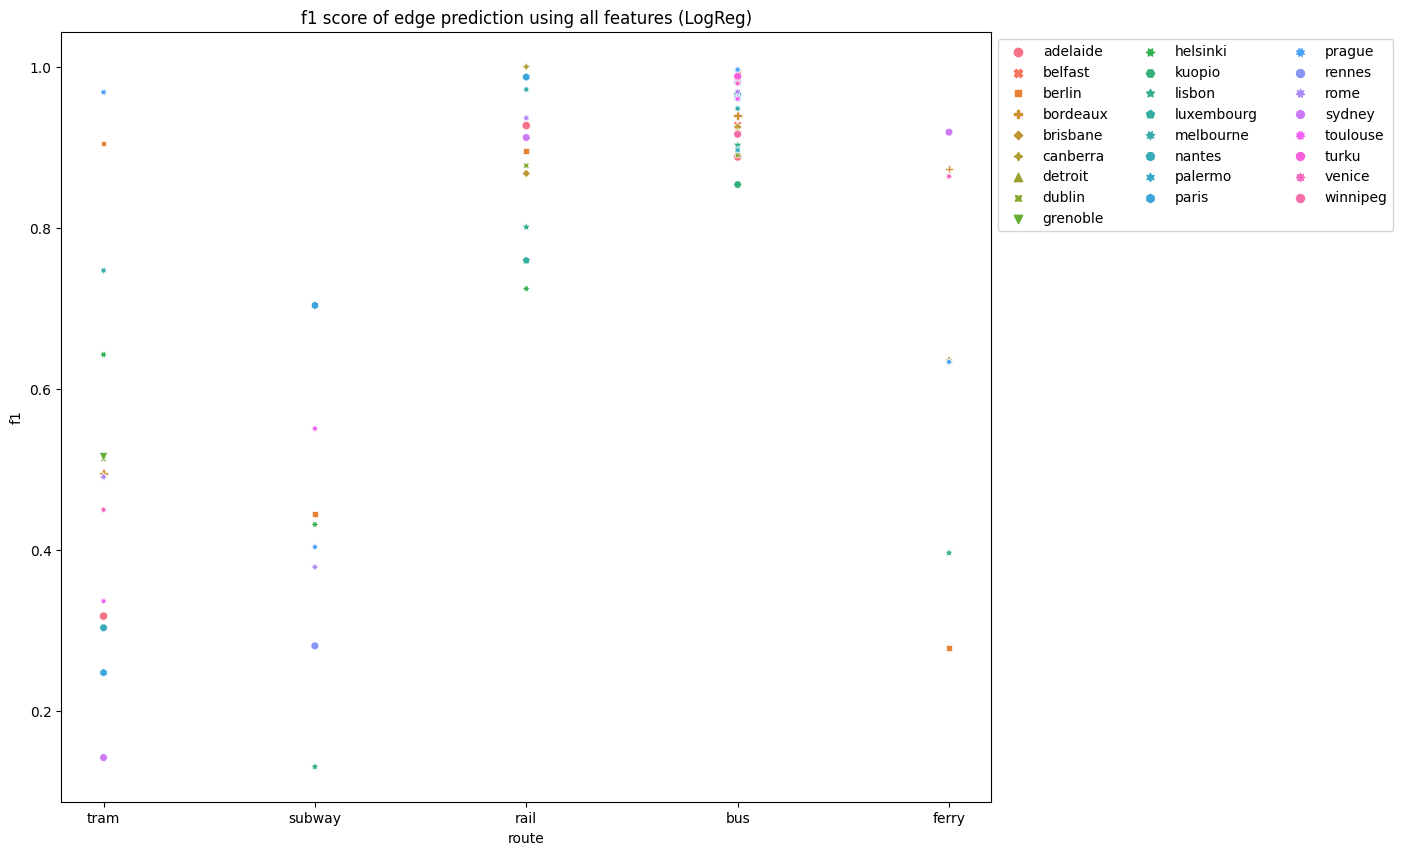

In [10]:
plot_scores(cities_graphs_scores_all_df, features="all")